In [81]:
from matplotlib import colors
from parse_dataset import *
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yaml

In [82]:
# '../config.yml', to be ignored via .gitignore, is assumed to exist in advance
with open('../config.yml', 'r') as inf:
    cfg_dict = yaml.safe_load(inf)

tf_dataset = get_dataset(cfg_dict['file_pattern'], 64)

# feature shape & data type inspection

In [83]:
train_cases = list(tf_dataset.as_numpy_iterator())
num_train_cases = len(train_cases)
feat_names = sorted(train_cases[0].keys())
print('* total # of training cases: {}'.format(num_train_cases))
print('* type of each train case: {}'.format(type(train_cases[0])))
print('* feature names in sorted order: {}'.format(feat_names))
print('* feature config:')
line_format = '{:>20s}{:>20s}{:>20s}'
header = line_format.format('feature name', 'feature shape', 'dtype')
print('-' * len(header))
print(header)
print('-' * len(header))
for k, v in train_cases[0].items():
    print(line_format.format(k, str(v.shape), str(v.dtype)))
print('-' * len(header))

* total # of training cases: 14979
* type of each train case: <class 'dict'>
* feature names in sorted order: ['FireMask', 'NDVI', 'PrevFireMask', 'elevation', 'erc', 'pdsi', 'population', 'pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs']
* feature config:
------------------------------------------------------------
        feature name       feature shape               dtype
------------------------------------------------------------
            FireMask            (64, 64)             float32
                NDVI            (64, 64)             float32
        PrevFireMask            (64, 64)             float32
           elevation            (64, 64)             float32
                 erc            (64, 64)             float32
                pdsi            (64, 64)             float32
          population            (64, 64)             float32
                  pr            (64, 64)             float32
                 sph            (64, 64)             float32
                  th

# [baseline] cleansing for each numeric feature by the original authors' criteria

In [84]:
# cleansing by the original authors' criteria in their repo

numeric_feat_names = [feat_name for feat_name in feat_names
                      if feat_name not in ['PrevFireMask', 'FireMask']]
feat_val = {}
for feat_name in numeric_feat_names:
    feat_val[feat_name] = []
    for train_case in train_cases:
        feat_val[feat_name].extend(train_case[feat_name].reshape(-1))

clip_bounds = {
    # 0.1 percentile, 99.9 percentile
    'elevation': tuple(np.percentile(feat_val['elevation'], (0.1, 99.9))),
    # Pressure: 0.1 percentile, 99.9 percentile
    'pdsi': tuple(np.percentile(feat_val['pdsi'], (0.1, 99.9))),
    'NDVI': tuple(np.percentile(feat_val['NDVI'], (0.1, 99.9))),
    # Precipitation in mm. Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, np.percentile(feat_val['pr'], 99.9)),
    # Specific humidity. Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0.0, 1.0),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0.0, 360.0),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.2, np.percentile(feat_val['tmmn'], 99.9)),
    'tmmx': (253.2, np.percentile(feat_val['tmmx'], 99.9)),
    # Wind velocity. Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, np.percentile(feat_val['vs'], 99.9)),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot. Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, np.percentile(feat_val['erc'], 99.9)),
    # Population: min(set to zero), 99.9 percentile
    'population': (0.0, np.percentile(feat_val['population'], 99.9))
}

for feat_name in numeric_feat_names:
    feat_val[feat_name] = [max(min(val, clip_bounds[feat_name][1]), clip_bounds[feat_name][0])
                           for val in feat_val[feat_name]]

# [baseline] descriptive statistics

In [85]:
# descriptive statistics for each numeric feature

feat_summary = {}

for feat_name in numeric_feat_names:
    feat_summary[feat_name] = {}
    feat_summary[feat_name]['size'] = len(feat_val[feat_name])
    feat_summary[feat_name]['min'] = np.min(feat_val[feat_name])
    feat_summary[feat_name]['1stQtr'] = np.percentile(feat_val[feat_name], 25)
    feat_summary[feat_name]['2ndQtr'] = np.percentile(feat_val[feat_name], 50)
    feat_summary[feat_name]['3rdQtr'] = np.percentile(feat_val[feat_name], 75)
    feat_summary[feat_name]['max'] = np.max(feat_val[feat_name])
    feat_summary[feat_name]['mean'] = np.mean(feat_val[feat_name])
    feat_summary[feat_name]['std'] = np.std(feat_val[feat_name])

stat_names = ['size', 'min', '1stQtr', '2ndQtr', '3rdQtr', 'max', 'mean', 'std']
header = '{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}'.format(
    'feature name', *stat_names)
print(header)
print('-' * len(header))

for feat_name in numeric_feat_names:
    print('{:>12s}{:>12d}{}'.format(
        feat_name, feat_summary[feat_name]['size'],
        ''.join(['{:>12.3f}'.format(feat_summary[feat_name][stat_name])
                 for stat_name in stat_names[1:]])))

feature name        size         min      1stQtr      2ndQtr      3rdQtr         max        mean         std
------------------------------------------------------------------------------------------------------------
        NDVI    61353984   -3826.000    3735.000    5520.000    7123.000    9282.000    5351.794    2179.282
   elevation    61353984       0.000     119.000     611.000    1595.000    3536.000     896.443     842.187
         erc    61353984       0.000      30.999      49.440      75.067     109.925      53.468      25.084
        pdsi    61353984      -6.056      -2.609      -1.355       1.189       6.743      -0.773       2.437
  population    61353984       0.000       0.000       0.166       3.538    2935.755      29.357     190.026
          pr    61353984       0.000       0.000       0.000       0.000      19.242       0.319       1.439
         sph    61353984       0.000       0.004       0.006       0.008       0.086       0.007       0.004
          th    613

# [baseline] histogram

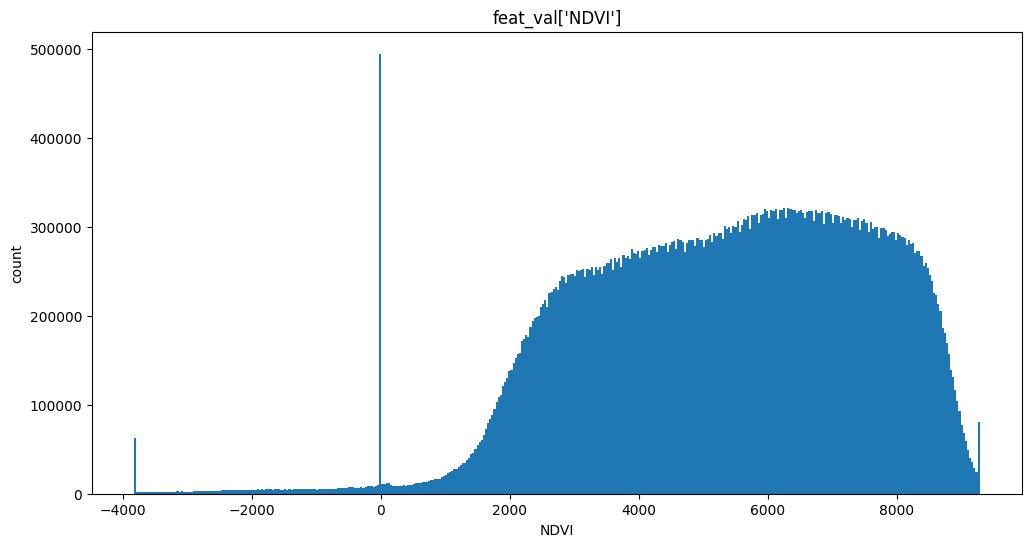

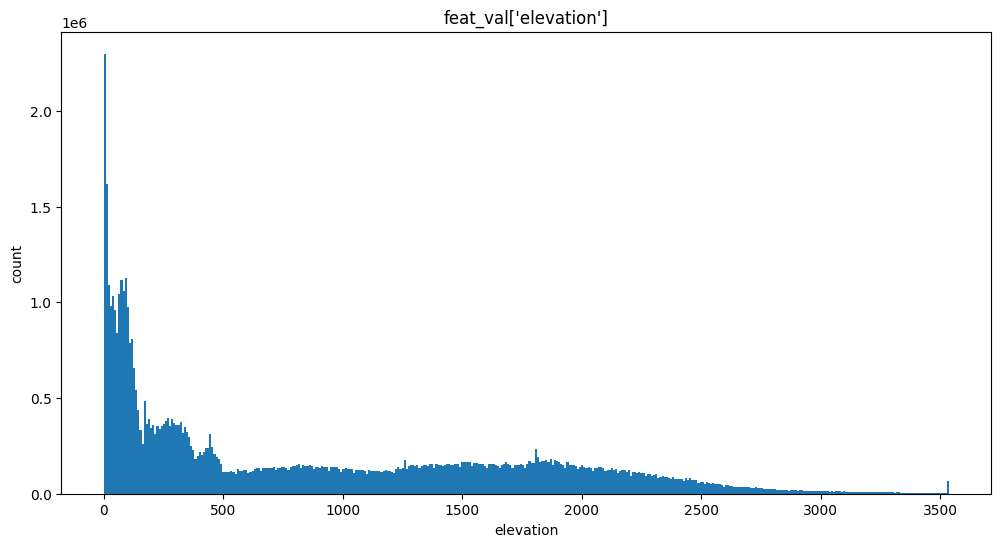

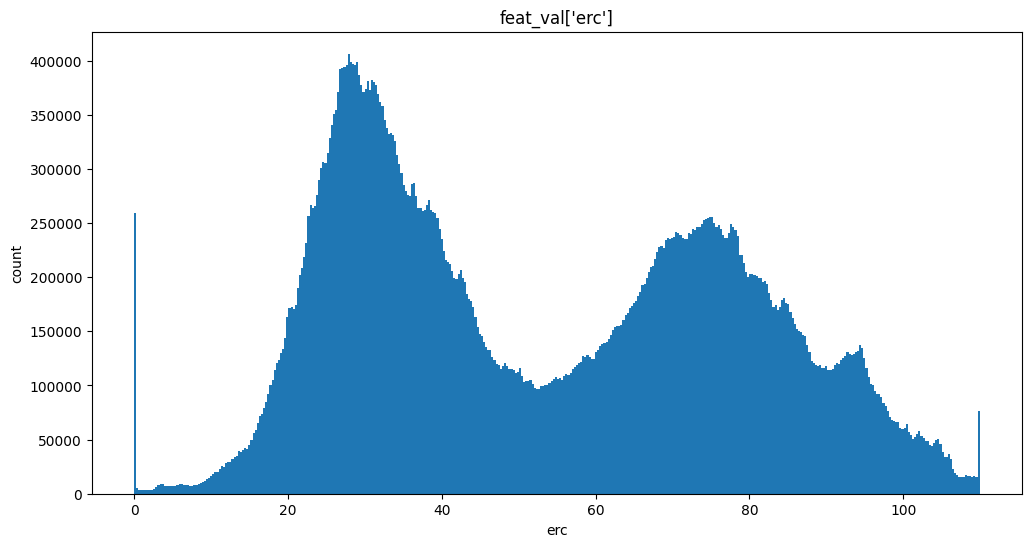

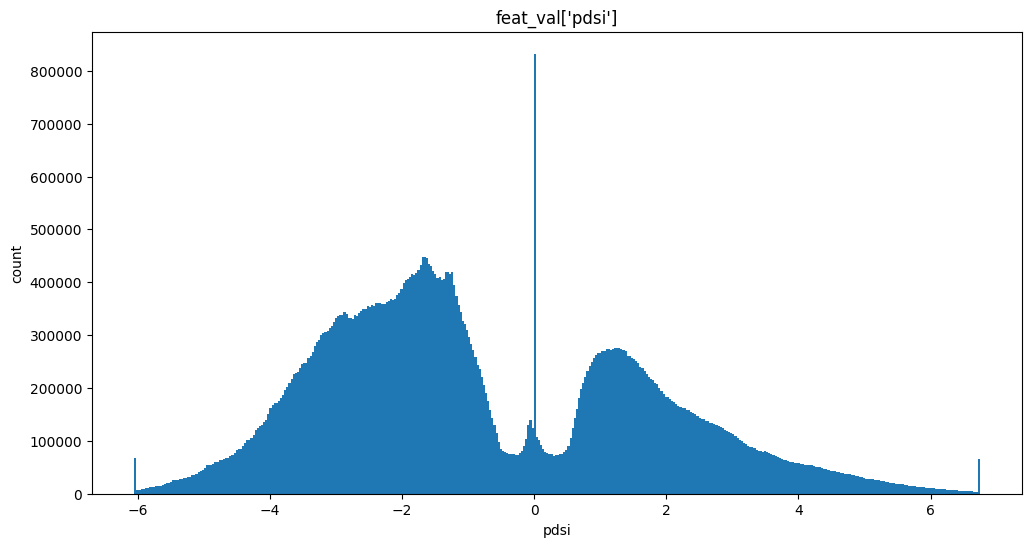

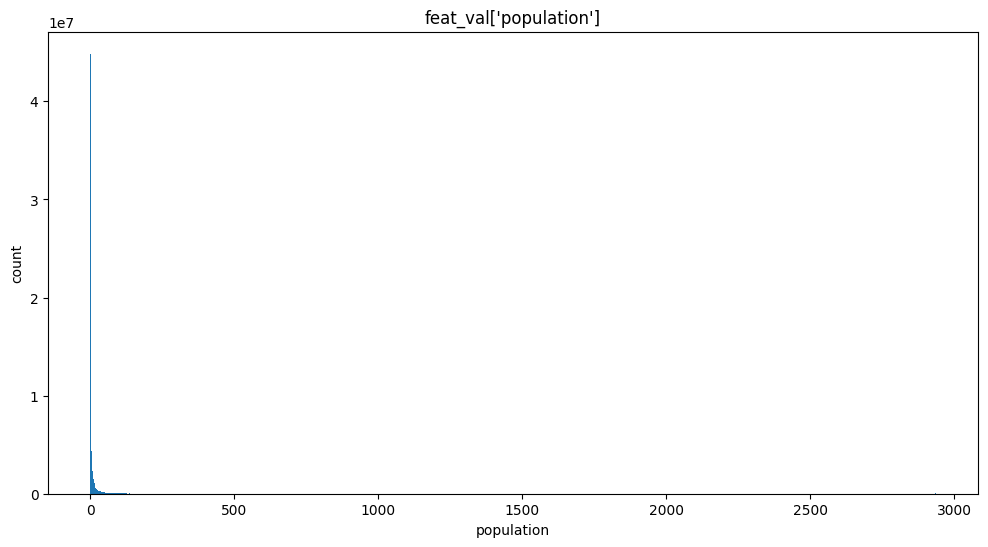

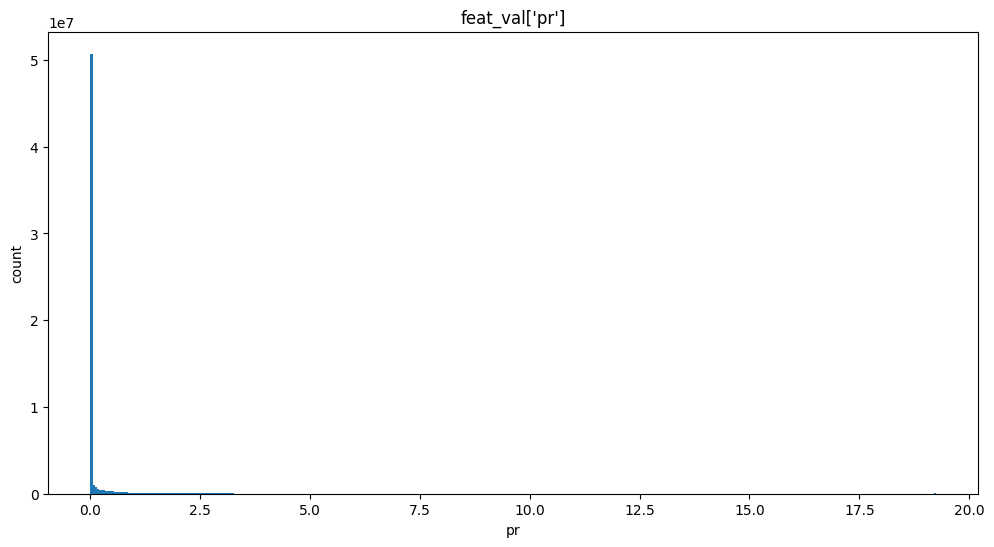

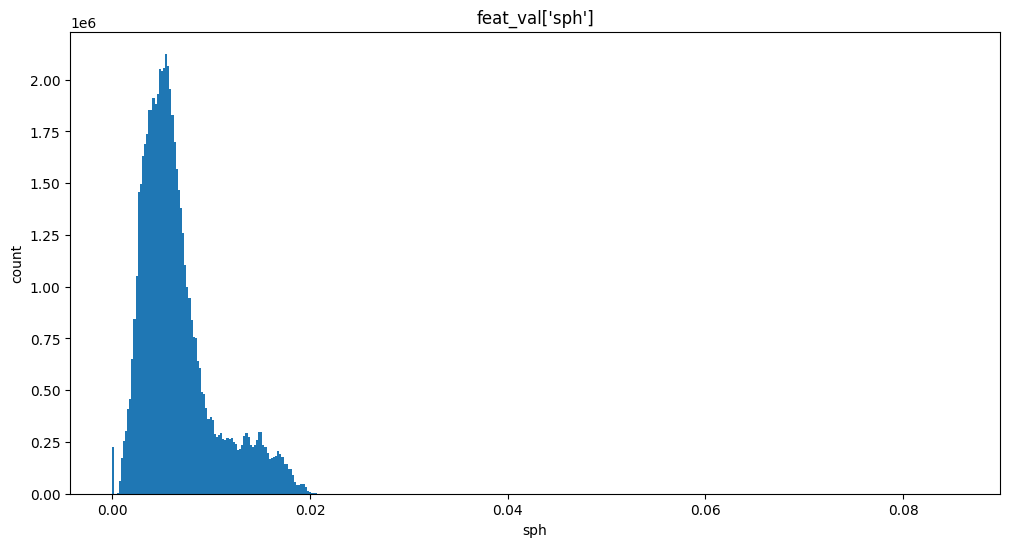

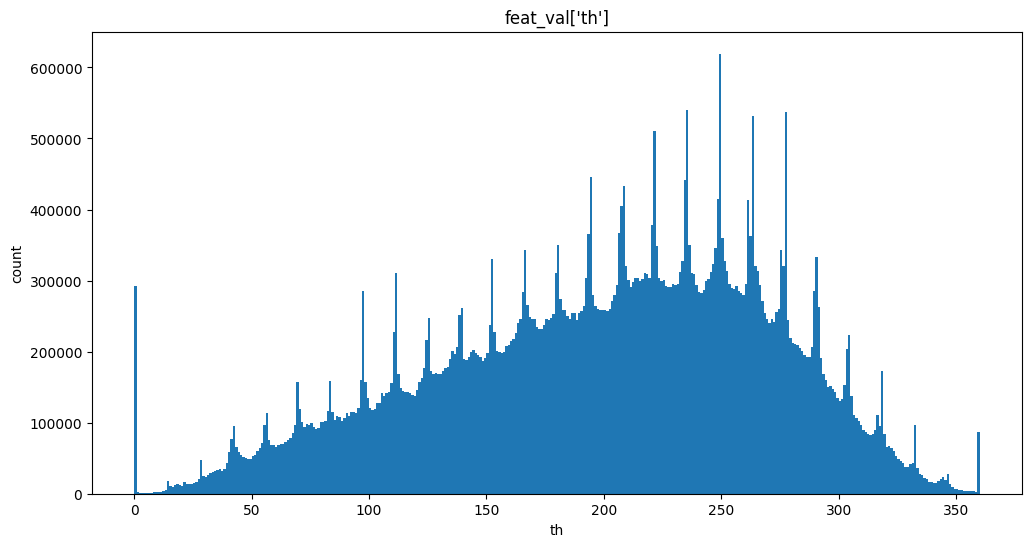

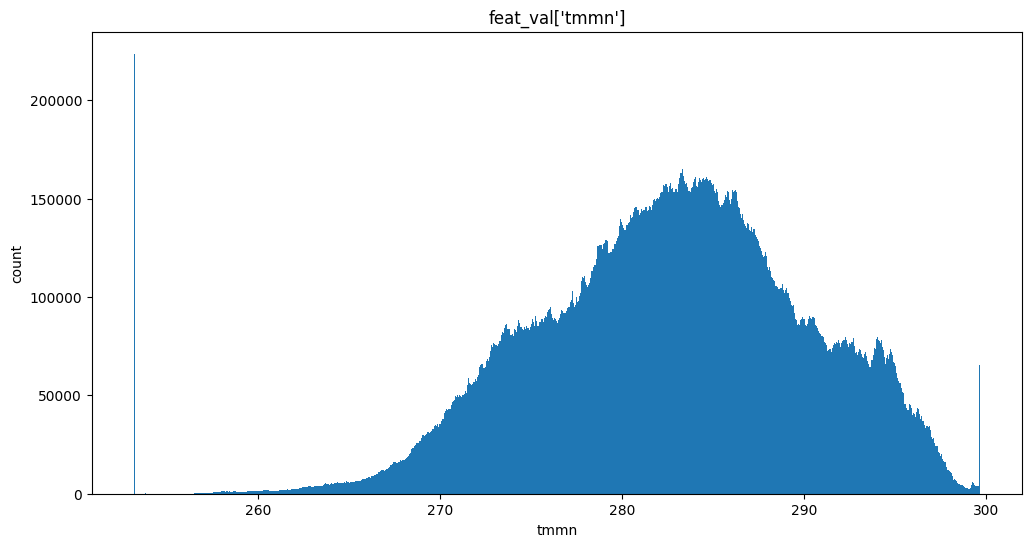

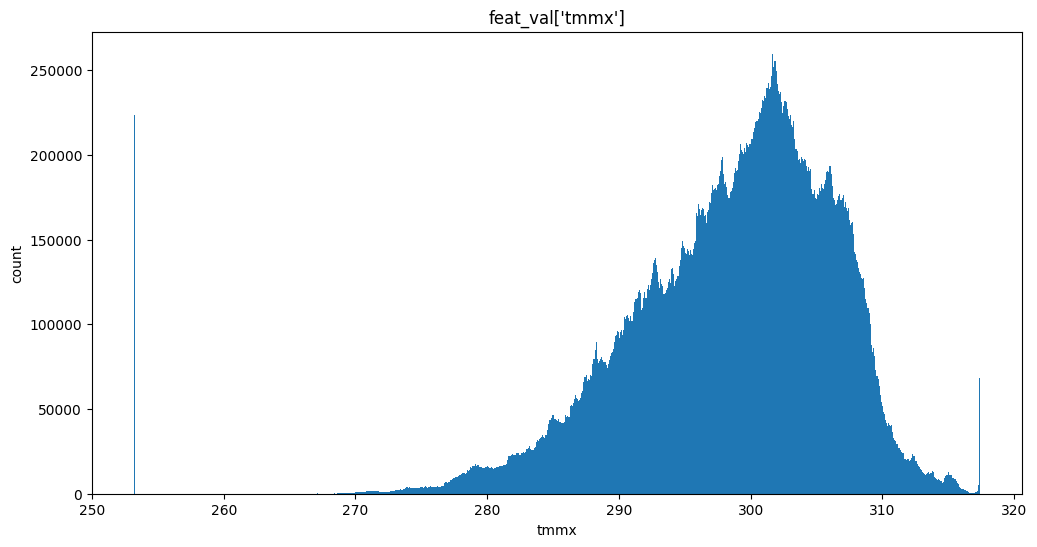

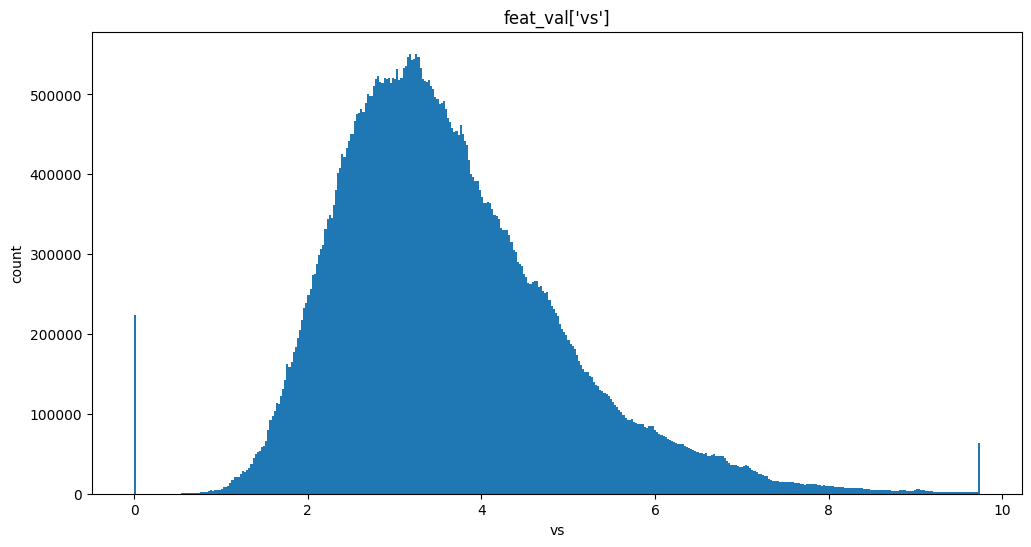

In [86]:
feat_bins = {'NDVI': 400, 'elevation': 400, 'erc': 400, 'pdsi': 400, 'population': 1000,
             'pr': 400, 'sph': 400, 'th': 360, 'tmmn': 1000, 'tmmx': 1000, 'vs': 400}

for feat_name in numeric_feat_names:
    plt.figure(figsize=(12, 6))  # (width, height) in inch
    plt.hist(feat_val[feat_name], bins=feat_bins[feat_name])
    plt.xlabel(feat_name)
    plt.ylabel('count')
    plt.title(f"feat_val['{feat_name}']")
    plt.show()

# [alternative] additional cleansing for each numeric feature in different ways

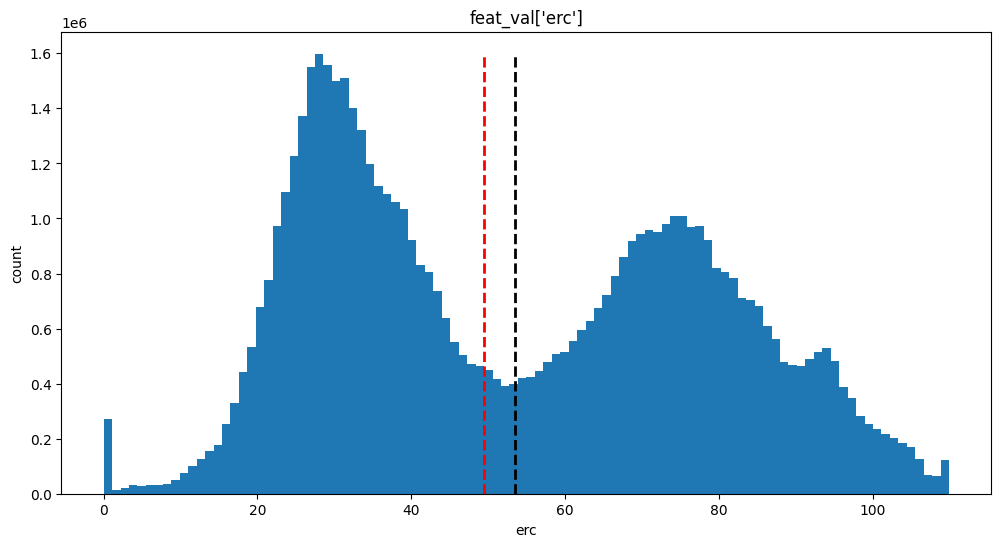

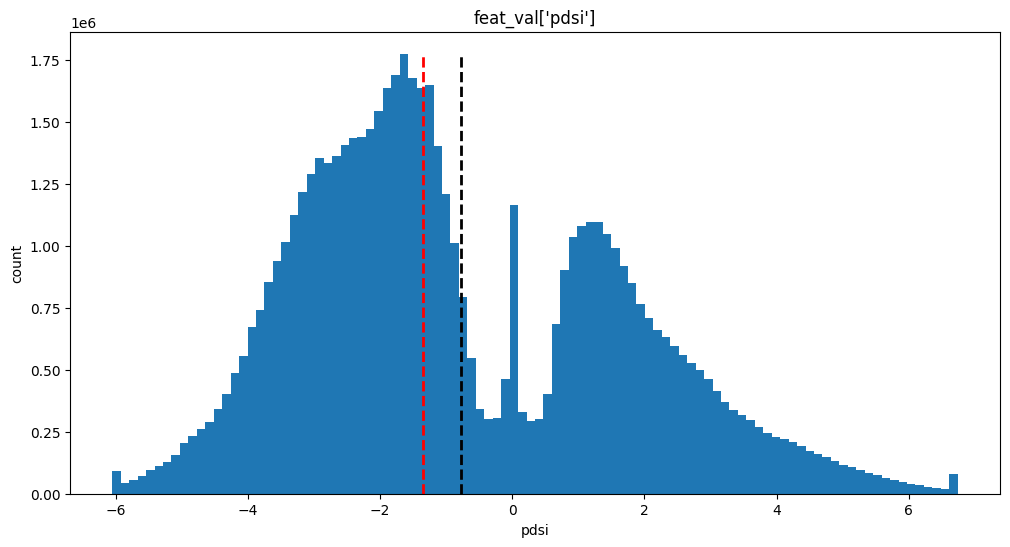

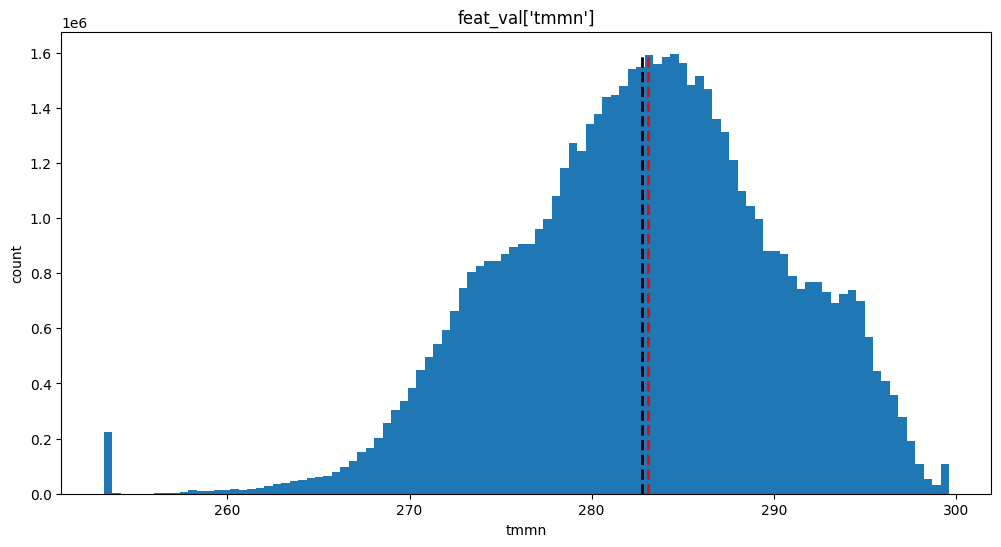

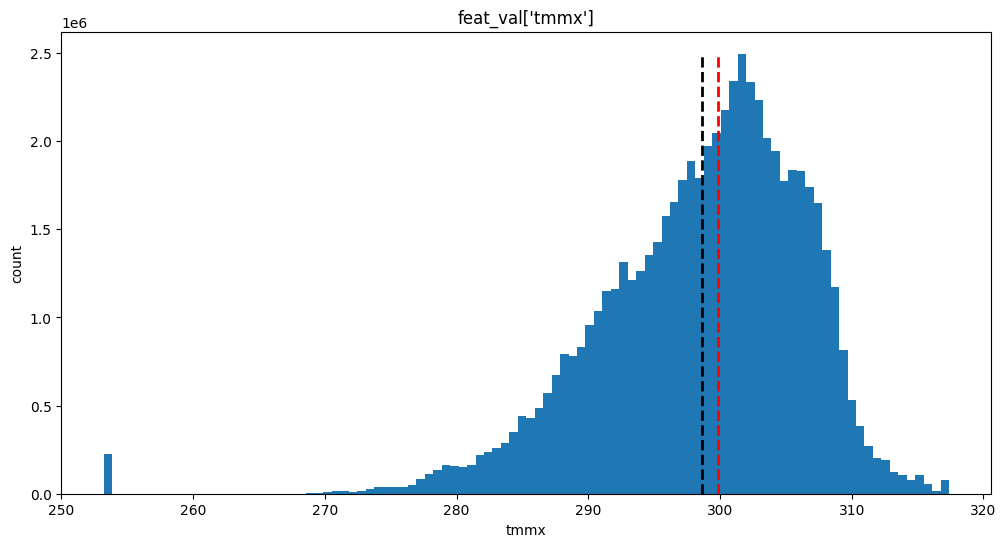

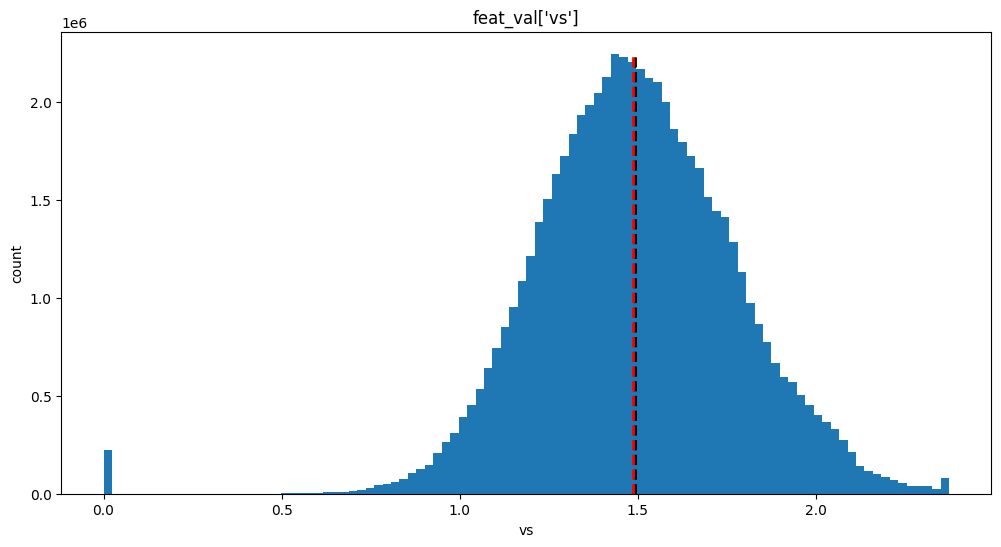

In [87]:
# group 1: long tails(erc, pdsi, tmmn, tmmx, vs)

group1 = {'erc': (0.0, 120.0), 'pdsi': (-12.5, 12.5), 'tmmn': (253.2, 320.0),
          'tmmx': (253.2, 350.0), 'vs': (0.0, 10.0)}

for feat_name in group1:
    feat_val[feat_name] = [max(min(val, group1[feat_name][1]), group1[feat_name][0])
                           for val in feat_val[feat_name]]

feat_val['vs'] = [log(val + 1) for val in feat_val['vs']]

for feat_name in group1:
    plt.figure(figsize=(12, 6))  # (width, height) in inch
    bin_vals, bin_edges, _ = plt.hist(feat_val[feat_name], bins=100)
    plt.xlabel(feat_name)
    plt.ylabel('count')
    plt.title(f"feat_val['{feat_name}']")
    feat_mean = np.mean(feat_val[feat_name])
    feat_median = np.percentile(feat_val[feat_name], 50)
    max_bin_val = np.max(bin_vals)
    plt.plot([feat_mean, feat_mean], [0, max_bin_val], color='black',
             linestyle='dashed', linewidth=2)  # mean
    plt.plot([feat_median, feat_median], [0, max_bin_val], color='red',
             linestyle='dashed', linewidth=2)  # median
    plt.show()

total # of cases: 61353984
positive # of pr cases: 15368834
portion of positives: 25.04944748168269 %


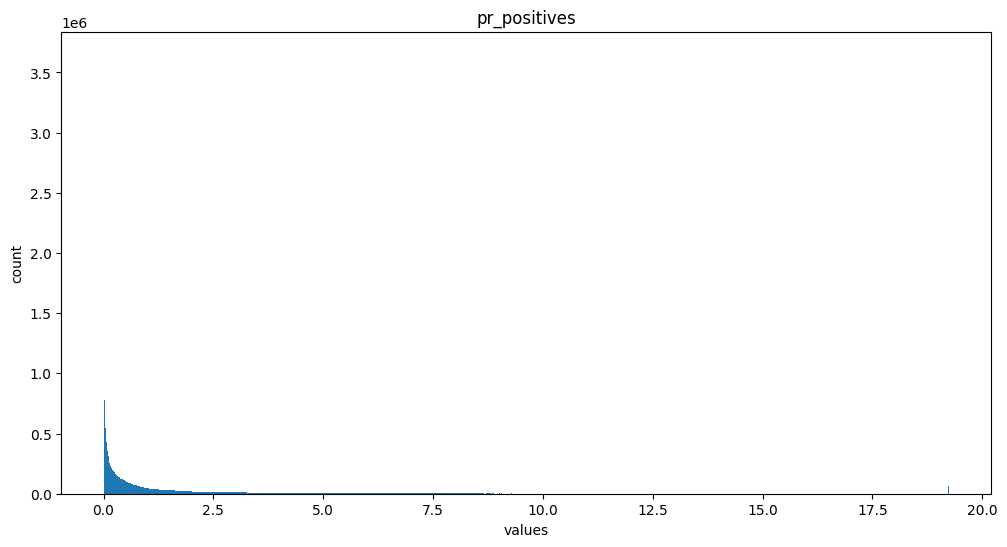

In [88]:
# group 2: extreme skew(elevation, population, pr)

# take 'pr' for test

from math import log

pr_positives = sorted([val for val in feat_val['pr'] if val > 0])
print('total # of cases: {}'.format(feat_summary['pr']['size']))
print('positive # of pr cases: {}'.format(len(pr_positives)))
print('portion of positives: {} %'.format(100 * len(pr_positives) / feat_summary['pr']['size']))

plt.figure(figsize=(12, 6))  # (width, height) in inch
plt.hist(pr_positives, bins=1000)
plt.xlabel('values')
plt.ylabel('count')
plt.title('pr_positives')
plt.show()


In [89]:
print('len: {}'.format(len(pr_positives)))
print('min: {}'.format(np.min(pr_positives)))
# print('1stQtr: {}'.format(np.percentile(pr_positives, 25)))
# print('2ndQtr: {}'.format(np.percentile(pr_positives, 50)))
# print('3rdQtr: {}'.format(np.percentile(pr_positives, 75)))
percentiles = []
for i in range(5, 100, 5):
    j = np.percentile(pr_positives, i)
    print('{}%: {}'.format(i, j))
    percentiles.append(j)
print('max: {}'.format(np.max(pr_positives)))

len: 15368834
min: 9.279332758047954e-16
5%: 3.462294989731163e-05
10%: 0.000276697613298893
15%: 0.0024089507525786756
20%: 0.009684707969427109
25%: 0.023173484951257706
30%: 0.04416238181293003
35%: 0.07530456781387329
40%: 0.11958069503307345
45%: 0.17869650423526767
50%: 0.2553294003009796
55%: 0.34990090131759644
60%: 0.4702783107757566
65%: 0.6228133618831644
70%: 0.8317169547080994
75%: 1.137887328863144
80%: 1.5938704967498782
85%: 2.334372055530548
90%: 3.6383925914764506
95%: 6.555721187591548
max: 19.242182199478265


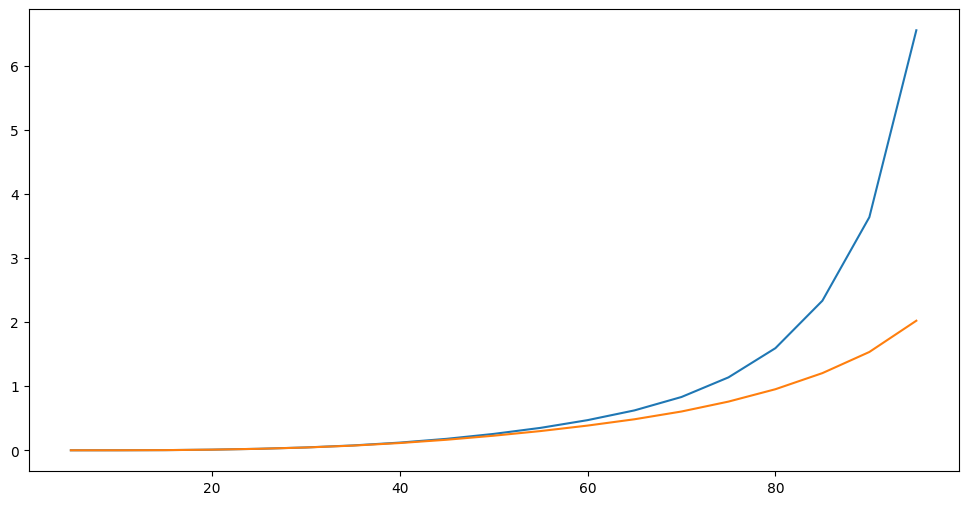

In [90]:
log_percentiles = []
for val in percentiles:
    log_percentiles.append(log(val + 1))
plt.figure(figsize=(12, 6))
plt.plot(list(range(5, 100, 5)), percentiles)
plt.plot(list(range(5, 100, 5)), log_percentiles)
plt.show()